In [1]:
import sys
from pathlib import Path

# Add project root to sys.path (so config.py is found)
root = Path().resolve().parent  # one level up from notebooks/
sys.path.append(str(root))

from config import RAW_DIR, INTERIM_DIR
import pandas as pd

print("RAW_DIR:", RAW_DIR)
print("INTERIM_DIR:", INTERIM_DIR)


RAW_DIR: C:\DataProjects\uh-ds-housing-data\data\raw
INTERIM_DIR: C:\DataProjects\uh-ds-housing-data\data\interim


In [2]:
# ============================================================
# 02_EDA.ipynb
# UK Housing Price Paid Dataset (2010–2017)
# ============================================================

# === 1️ Imports & Setup ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
from config import INTERIM_DIR

# Matplotlib & seaborn setup
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14

# === 2️ Load Data ===
file_path = INTERIM_DIR / "uk_housing_2010_2017.csv"
print(f"Loading dataset from: {file_path}")

df = pd.read_csv(file_path, parse_dates=["date_of_transfer"])
print(" Loaded:", df.shape)
df.head()


Loading dataset from: C:\DataProjects\uh-ds-housing-data\data\interim\uk_housing_2010_2017.csv
 Loaded: (6200823, 10)


price date_of_transfer property_type old_new duration       town_city  \
0   54000       2010-12-15             T       N        L         SWANSEA   
1  242950       2010-12-03             F       Y        L        FERNDOWN   
2  220000       2010-02-19             D       Y        F      BRIDGNORTH   
3   72000       2010-12-20             T       N        F      SUNDERLAND   
4  159500       2010-12-20             S       N        F  BURNHAM-ON-SEA   

      district         county ppdcategory_type record_status  
0      SWANSEA        SWANSEA                A             A  
1  EAST DORSET         DORSET                A             A  
2   SHROPSHIRE     SHROPSHIRE                A             A  
3   SUNDERLAND  TYNE AND WEAR                A             A  
4    SEDGEMOOR       SOMERSET                A             A

In [3]:
# === 3️ Data Overview ===
df.info()

# Count missing values
missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing Values:\n", missing[missing > 0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6200823 entries, 0 to 6200822
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   price             int64         
 1   date_of_transfer  datetime64[ns]
 2   property_type     object        
 3   old_new           object        
 4   duration          object        
 5   town_city         object        
 6   district          object        
 7   county            object        
 8   ppdcategory_type  object        
 9   record_status     object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 473.1+ MB

Missing Values:
 Series([], dtype: int64)


  date_of_transfer  year  month
0       2010-12-15  2010     12
1       2010-12-03  2010     12
2       2010-02-19  2010      2
3       2010-12-20  2010     12
4       2010-12-20  2010     12


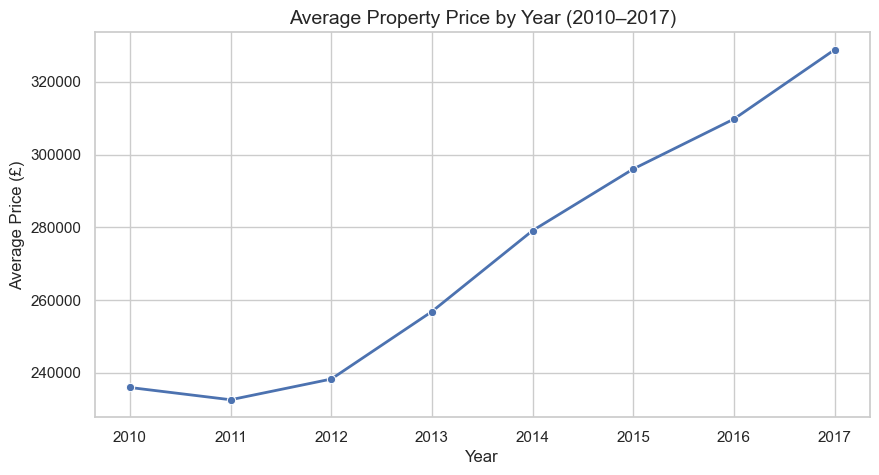

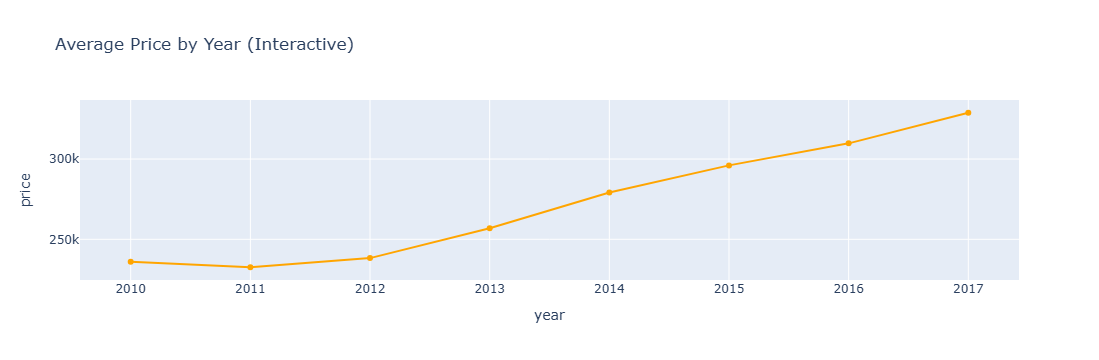

In [4]:
# === 5️ Average Price by Year ===
# === Create Year and Month Columns ===
df["year"] = df["date_of_transfer"].dt.year
df["month"] = df["date_of_transfer"].dt.month

print(df[["date_of_transfer", "year", "month"]].head())

yearly = df.groupby("year")["price"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=yearly, x="year", y="price", marker="o", linewidth=2)
plt.title("Average Property Price by Year (2010–2017)")
plt.ylabel("Average Price (£)")
plt.xlabel("Year")
plt.show()

# Interactive Plotly version
fig = px.line(yearly, x="year", y="price", title="Average Price by Year (Interactive)")
fig.update_traces(line_color="orange", mode="lines+markers")
fig.show()


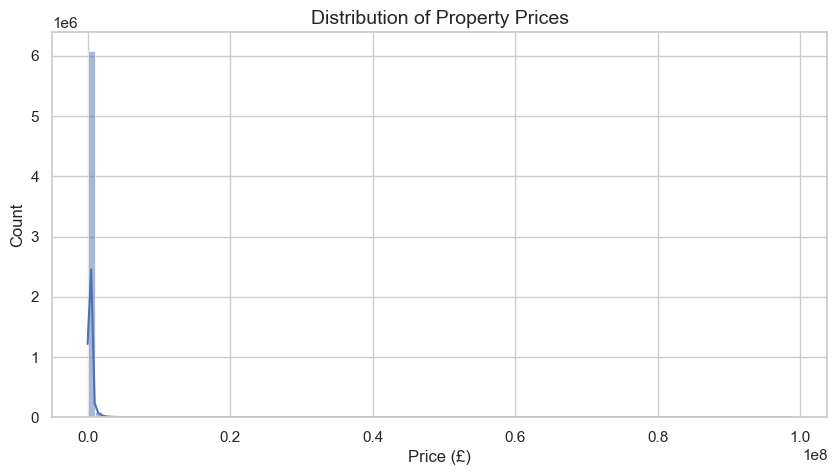

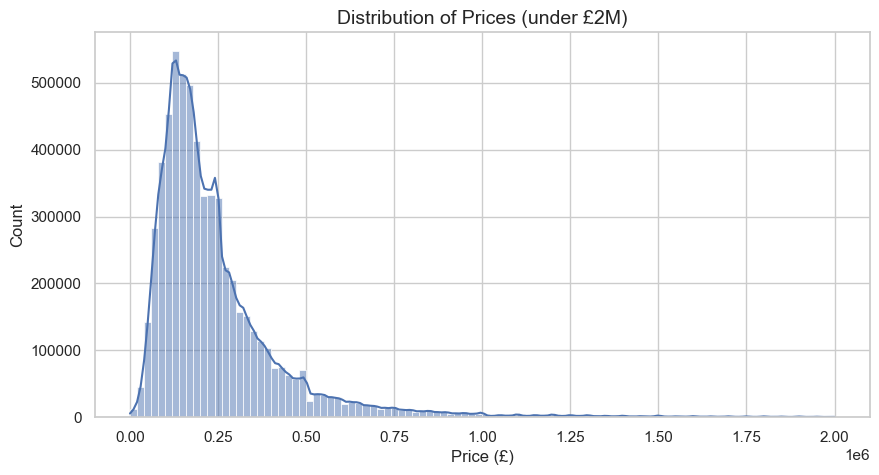

In [5]:
# === 6️ Price Distribution ===
plt.figure(figsize=(10,5))
sns.histplot(df["price"], bins=100, kde=True)
plt.title("Distribution of Property Prices")
plt.xlabel("Price (£)")
plt.show()

# Limit axis for better visibility (exclude outliers)
plt.figure(figsize=(10,5))
sns.histplot(df[df["price"] < 2_000_000]["price"], bins=100, kde=True)
plt.title("Distribution of Prices (under £2M)")
plt.xlabel("Price (£)")
plt.show()


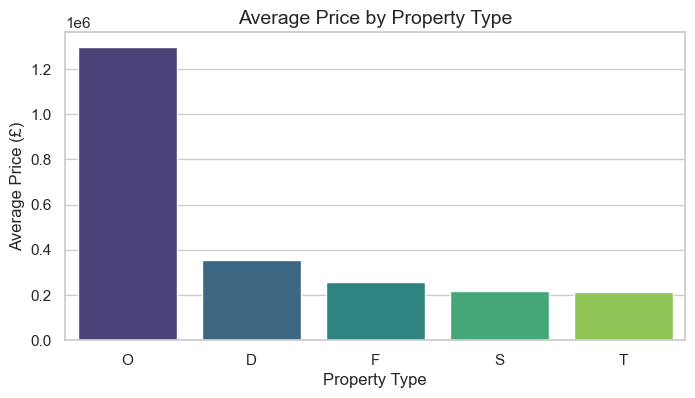

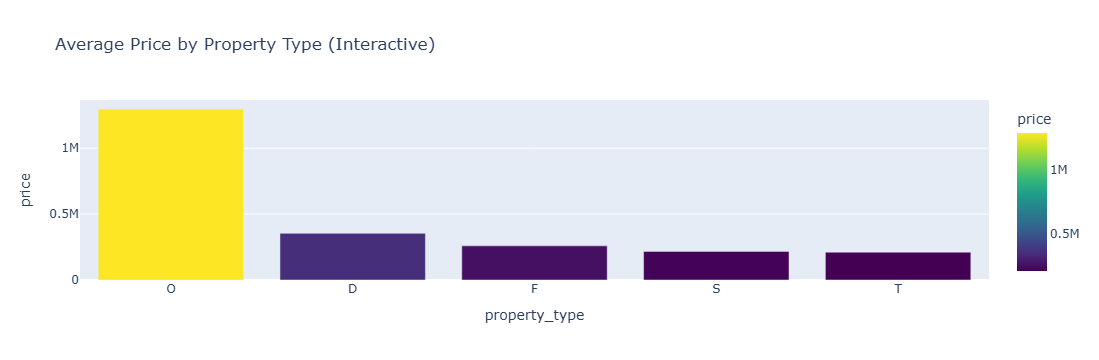

In [6]:
# === 7️ Average Price by Property Type ===
type_avg = df.groupby("property_type")["price"].mean().reset_index().sort_values(by="price", ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(data=type_avg, x="property_type", y="price", hue="property_type",
            palette="viridis", legend=False)
plt.title("Average Price by Property Type")
plt.xlabel("Property Type")
plt.ylabel("Average Price (£)")
plt.show()

# Interactive Plotly bar
fig = px.bar(type_avg, x="property_type", y="price", title="Average Price by Property Type (Interactive)",
             color="price", color_continuous_scale="Viridis")
fig.show()


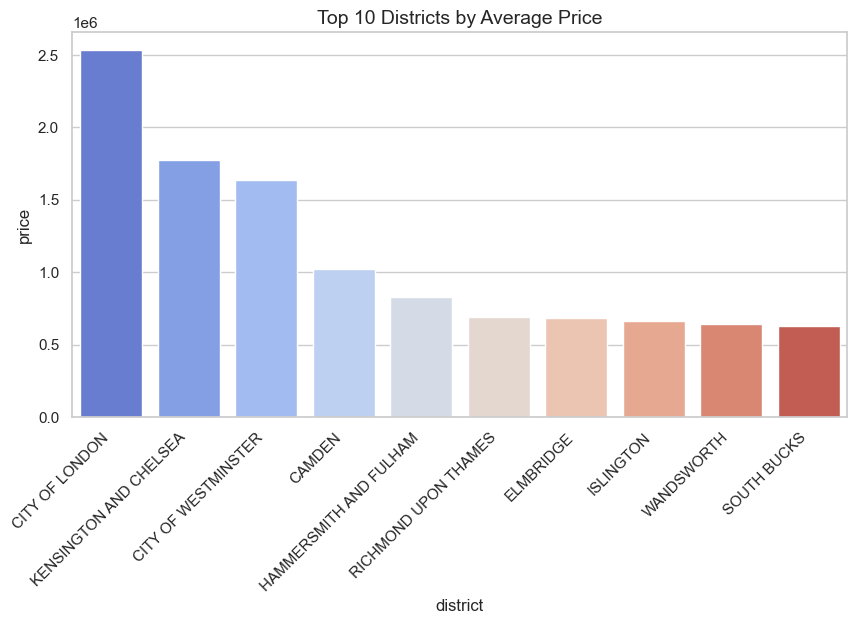

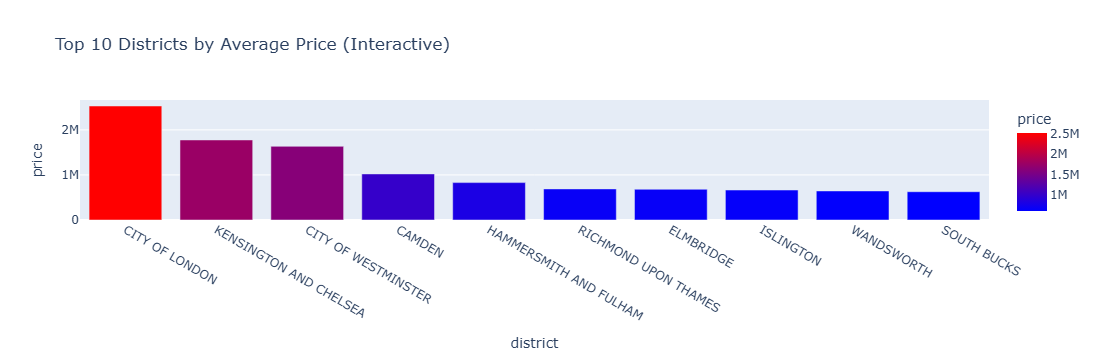

In [7]:
# === 8️ Top 10 Districts by Price ===
district_avg = df.groupby("district")["price"].mean().nlargest(10).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=district_avg, x="district", y="price", hue="district", 
            palette="coolwarm", legend=False)
plt.title("Top 10 Districts by Average Price")
plt.xticks(rotation=45, ha="right")
plt.show()

# Interactive map-style bar
fig = px.bar(district_avg, x="district", y="price", title="Top 10 Districts by Average Price (Interactive)",
             color="price", color_continuous_scale="Bluered")
fig.show()


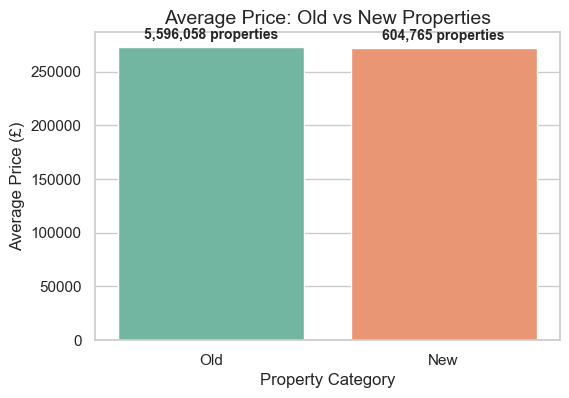

In [8]:
# === 9️ Old vs New Properties ===
# Average + counts
old_new_avg = df.groupby("old_new")["price"].mean().reset_index()
old_new_count = df["old_new"].value_counts().reset_index()
old_new_count.columns = ["old_new", "count"]

summary = pd.merge(old_new_avg, old_new_count, on="old_new")
summary["old_new"] = summary["old_new"].map({'N': 'Old', 'Y': 'New'})

plt.figure(figsize=(6,4))
ax = sns.barplot(data=summary, x="old_new", y="price", hue="old_new",
                 palette="Set2", legend=False)

# Add labels above bars
for i, row in summary.iterrows():
    plt.text(i, row["price"] + 5000, f"{int(row['count']):,} properties", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Average Price: Old vs New Properties")
plt.xlabel("Property Category")
plt.ylabel("Average Price (£)")
plt.show()


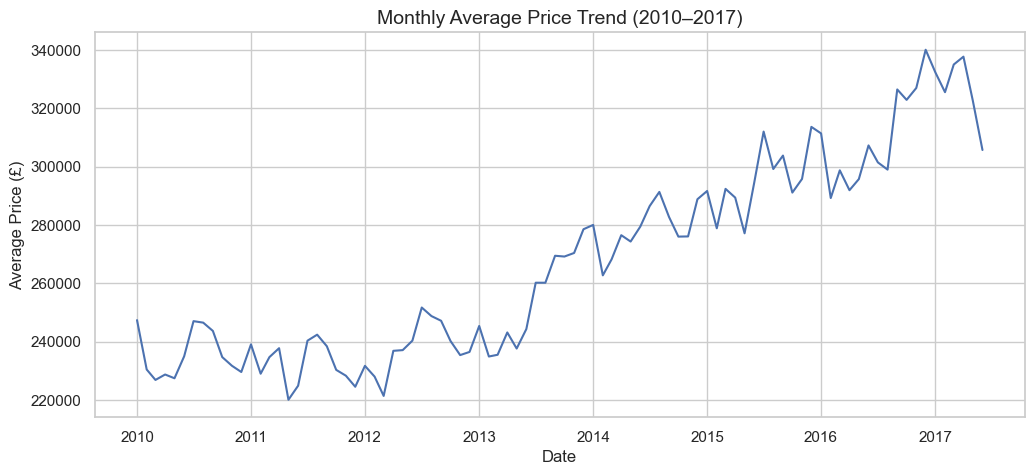

In [9]:
# === 10 Price Trend by Month ===
monthly = df.groupby(["year", "month"])["price"].mean().reset_index()
monthly["year_month"] = pd.to_datetime(monthly["year"].astype(str) + "-" + monthly["month"].astype(str))

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly, x="year_month", y="price")
plt.title("Monthly Average Price Trend (2010–2017)")
plt.ylabel("Average Price (£)")
plt.xlabel("Date")
plt.show()


# Section 8 — Inflation-Adjusted House Prices (Supervisor Feedback)

this section explores whether 
the observed rise in UK housing prices between 2010–2017 can be explained by inflation, 
or whether real (inflation-adjusted) prices also increased.

We adjust nominal house prices using the **UK Consumer Price Index (CPI)**, rebasing all prices to **2015 pounds**.  
The CPI reference data is taken from the UK Office for National Statistics (ONS).


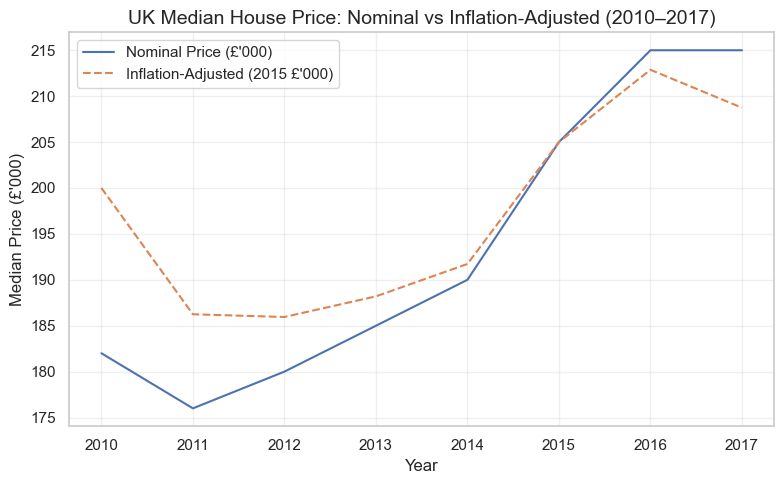

In [10]:
# === Inflation Adjustment ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CPI reference values (2015 = 100)
cpi_data = {
    2010: 91.0,
    2011: 94.5,
    2012: 96.8,
    2013: 98.3,
    2014: 99.1,
    2015: 100.0,
    2016: 101.0,
    2017: 103.0
}

cpi_df = pd.DataFrame(list(cpi_data.items()), columns=["year", "CPI"])

# Restrict data and merge CPI
df = df[df["year"].between(2010, 2017)]
df = df.merge(cpi_df, on="year", how="left")

# Adjust nominal price → real price (in 2015 pounds)
df["real_price_2015"] = df["price"] * (100 / df["CPI"])

# --- Compute annual medians for nominal vs real ---
price_trend = df.groupby("year")[["price", "real_price_2015"]].median().reset_index()

plt.figure(figsize=(8,5))
plt.plot(price_trend["year"], price_trend["price"]/1000, label="Nominal Price (£'000)")
plt.plot(price_trend["year"], price_trend["real_price_2015"]/1000, label="Inflation-Adjusted (2015 £'000)", linestyle="--")
plt.title("UK Median House Price: Nominal vs Inflation-Adjusted (2010–2017)")
plt.xlabel("Year")
plt.ylabel("Median Price (£'000)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
!pip install geopandas plotly


# Section 9 — Geographic Distribution of Housing Prices

This section visualises spatial differences in median house prices across the UK.  
Median values are computed per local authority and plotted on a **choropleth map** using Plotly + GeoPandas.

*(Supervisor note: “Plot the housing prices on a map of the UK, perhaps using libraries beyond Seaborn.”)*


In [13]:
print("Columns in df_infl:", df.columns.tolist())


Columns in df_infl: ['price', 'date_of_transfer', 'property_type', 'old_new', 'duration', 'town_city', 'district', 'county', 'ppdcategory_type', 'record_status', 'year', 'month', 'CPI', 'real_price_2015']


 Using geographic column: district
 Computed median price for 350 regions
 Merged and simplified 361 polygons


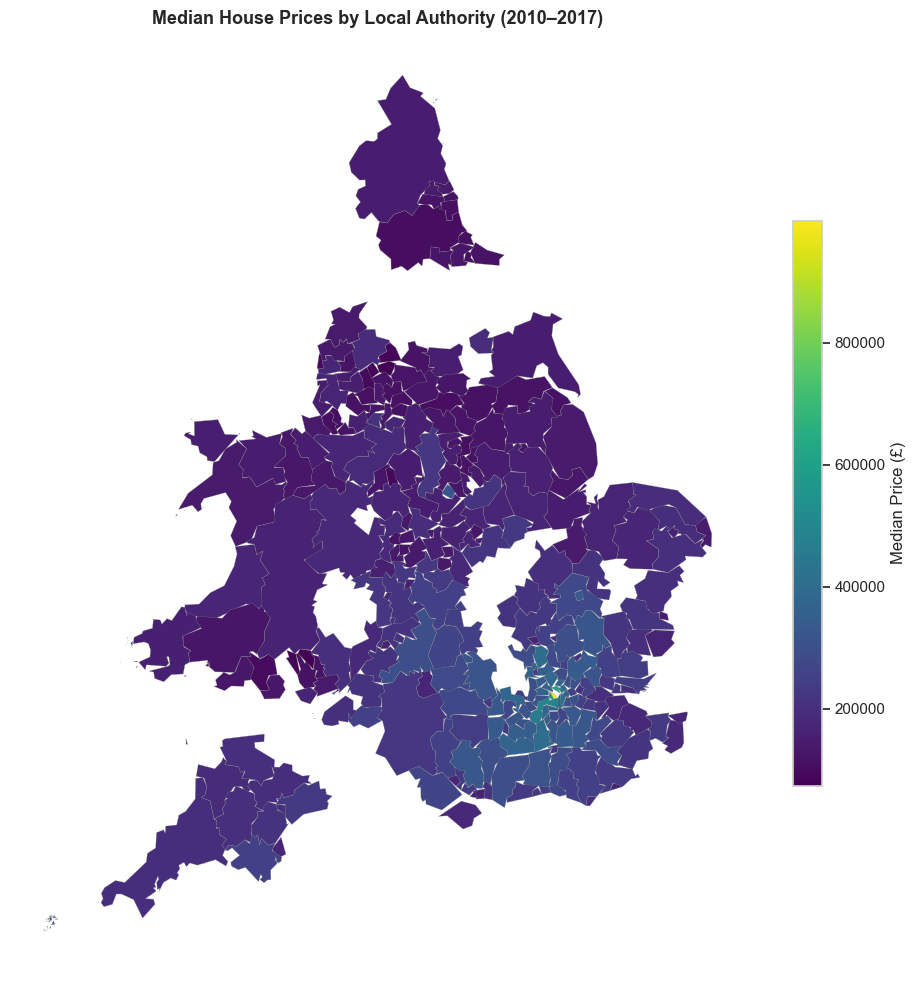

In [18]:
# === Fast Geographic Mapping ===
import geopandas as gpd
import matplotlib.pyplot as plt
from config import INTERIM_DIR

# 1️ Choose geographic column dynamically
geo_col = next((c for c in ["local_authority", "district", "county"] if c in df.columns), None)
if geo_col is None:
    raise KeyError(f"No geographic column found. Available: {df.columns.tolist()}")
print(f" Using geographic column: {geo_col}")

# 2️ Compute median price per region
map_df = df.groupby(geo_col, as_index=False)["price"].median()
map_df.rename(columns={geo_col: "local_authority", "price": "median_price"}, inplace=True)
print(f" Computed median price for {len(map_df)} regions")

# 3️ Load GeoJSON (ONS simplified boundaries recommended)
geo_path = INTERIM_DIR / "uk_districts.geojson"
uk_geo = gpd.read_file(geo_path)

# Auto-detect name column (handles LAD22NM, lad22nm, etc.)
name_col = next((c for c in uk_geo.columns if "lad" in c.lower() and "nm" in c.lower()), None)
if name_col is None:
    raise KeyError(f"Name column not found in GeoJSON. Columns: {uk_geo.columns.tolist()}")

# Normalise join keys
uk_geo["local_authority"] = uk_geo[name_col].str.lower().str.strip()
map_df["local_authority"] = map_df["local_authority"].str.lower().str.strip()

# 4️ Merge & simplify geometry for faster plotting
merged = uk_geo.merge(map_df, on="local_authority", how="left")
merged["geometry"] = merged["geometry"].simplify(tolerance=0.02, preserve_topology=True)
print(f" Merged and simplified {len(merged)} polygons")

# 5️ Plot static choropleth 
fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(
    column="median_price",
    cmap="viridis",
    linewidth=0.2,
    ax=ax,
    edgecolor="grey",
    legend=True,
    legend_kwds={"label": "Median Price (£)", "shrink": 0.6}
)
ax.set_title("Median House Prices by Local Authority (2010–2017)", fontsize=13, weight="bold")
ax.axis("off")
plt.tight_layout()
plt.show()


# Zoomed View: Greater London Housing Prices

This map focuses on the **Greater London** region, where housing prices 
are significantly above the UK median.  
It uses the same underlying geometry and price data but filters to London authorities.


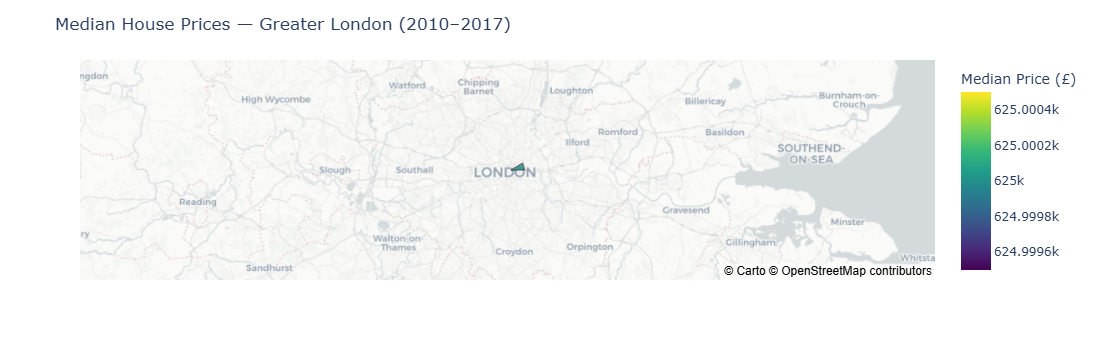

In [27]:
# === London Map ===
# Keeping only authorities whose name includes 'london'
london_df = merged[merged["local_authority"].str.contains("london", na=False)]

if len(london_df) > 0:
    fig_london = px.choropleth_mapbox(
        london_df,
        geojson=london_df.geometry,
        locations=london_df.index,
        color="median_price",
        color_continuous_scale="Viridis",
        mapbox_style="carto-positron",
        zoom=8,
        center={"lat": 51.51, "lon": -0.12},
        opacity=0.8,
        labels={"median_price":"Median Price (£)"}
    )
    fig_london.update_layout(title="Median House Prices — Greater London (2010–2017)")
    fig_london.show()
else:
    print("No London districts found in merged dataset — check local_authority naming.")


# House Prices vs Wage Growth

To further assess affordability, i compare inflation-adjusted median house prices 
against the **UK Average Weekly Earnings (AWE)** index (2015 = 100) sourced from the ONS.  
If housing prices rise faster than wages, real affordability deteriorates.


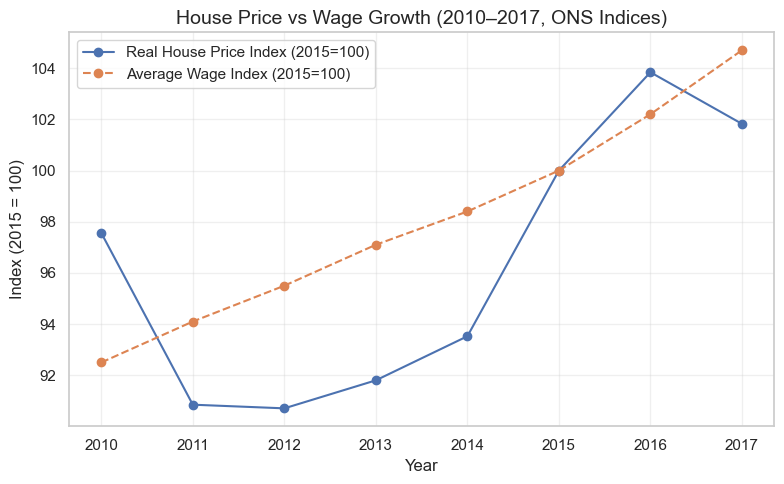

year  Real House Price Index (2015=100)    AWE
0  2010                          97.560976   92.5
1  2011                          90.850432   94.1
2  2012                          90.707519   95.5
3  2013                          91.802099   97.1
4  2014                          93.524649   98.4
5  2015                         100.000000  100.0
6  2016                         103.839652  102.2
7  2017                         101.823348  104.7

In [25]:
# === House Prices vs Wage Growth ===

trend = (
    df.groupby("year")[["price", "real_price_2015"]]
    .median()
    .reset_index()
)

#  AWE index (ONS, Whole Economy, 2015 = 100)
awe_index = {
    2010: 92.5,
    2011: 94.1,
    2012: 95.5,
    2013: 97.1,
    2014: 98.4,
    2015: 100.0,
    2016: 102.2,
    2017: 104.7
}
awe_df = pd.DataFrame(list(awe_index.items()), columns=["year", "AWE"])

# Merge and compute indices
price_wage = trend.merge(awe_df, on="year", how="left")
base_val = price_wage.loc[price_wage["year"] == 2015, "real_price_2015"].values[0]
price_wage["Real House Price Index (2015=100)"] = (
    price_wage["real_price_2015"] / base_val * 100
)

# Plot comparison
plt.figure(figsize=(8, 5))
plt.plot(
    price_wage["year"],
    price_wage["Real House Price Index (2015=100)"],
    marker="o",
    label="Real House Price Index (2015=100)"
)
plt.plot(
    price_wage["year"],
    price_wage["AWE"],
    marker="o",
    linestyle="--",
    label="Average Wage Index (2015=100)"
)
plt.title("House Price vs Wage Growth (2010–2017, ONS Indices)")
plt.xlabel("Year")
plt.ylabel("Index (2015 = 100)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

price_wage[["year", "Real House Price Index (2015=100)", "AWE"]]
